In [1]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
    sys.path.append(os.path.realpath("../../"))
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig

from keras.utils.visualize_util import plot
from IPython.display import Image, display

from CMS_SURF_2016.utils.preprocessing import ObjectProfile, preprocessFromPandas_label_dir_pairs, label_dir_pairs_args_decoder
from CMS_SURF_2016.utils.metrics import plot_history, print_accuracy_m
from CMS_SURF_2016.utils.callbacks import OverfitStopping, SmartCheckpoint
from CMS_SURF_2016.utils.archiving import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D, merge, Input, Flatten
from keras.callbacks import EarlyStopping


dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')




Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.
using gpu0
using theano


In [2]:
#The observables taken from the table
observ_types = ['E/c', 'Px', 'Py', 'Pz', 'Charge', "PT_ET", "Eta", "Phi", "Dxy_Ehad_Eem"]
set_size = 5
vecsize = len(observ_types)
epochs = 100
batch_size = 100
sample_start = 0
num_samples = 10000


object_profiles = [ObjectProfile("Electron",5),
                    ObjectProfile("MuonTight", 5),
                    ObjectProfile("Photon", 25),
                    ObjectProfile("MissingET", 1),
                    ObjectProfile("EFlowPhoton",1000, sort_columns=["PT_ET"], sort_ascending=False),  #1300
                    ObjectProfile("EFlowNeutralHadron",1000, sort_columns=["PT_ET"], sort_ascending=False),  #1000
                    ObjectProfile("EFlowTrack",1000, sort_columns=["PT_ET"], sort_ascending=False)]  #1050


label_dir_pairs = \
            [   ("ttbar", "/data/shared/Delphes/ttbar_lepFilter_13TeV/pandas_unjoined/"),
                ("wjet", "/data/shared/Delphes/wjets_lepFilter_13TeV/pandas_unjoined/")#,#
#                ("qcd", "/data/shared/Delphes/qcd_lepFilter_13TeV/pandas_unjoined/")
            ]
#ttbar_files = glob.glob("/data/shared/Delphes/ttbar_lepFilter_13TeV/pandas_unjoined/*.h5")
#WJet_files = glob.glob("/data/shared/Delphes/wjets_lepFilter_13TeV/pandas_unjoined/*.h5")
#qcd_files = glob.glob("/data/shared/Delphes/qcd_lepFilter_13TeV/pandas_unjoined/*.h5")

#files = {0:ttbar_files, 1:WJet_files}


In [3]:
#X_train, y_train = preprocessFromPandas_label_dir_pairs(label_dir_pairs, sample_start, num_samples, object_profiles,observ_types)

In [4]:
#print(len(X_train["Electron"]))
#X_train

        

In [5]:
histories = {}
cull=False
add_title = "_AllParticles"
#for i in range (1):

def build_decay(start, n, end=0):
    v = np.arange(start, end, -int(np.ceil( max((start-end)/float(n), 1) )))
    return v
    

#X_train, y_train = preprocessFromPandas_file_label_pairs(files, cull=False)
#X_train_flatten = [None] * len(object_profiles)
def genModel(depth):
    inputs = [None] * len(object_profiles)
    first_dense = [None] * len(object_profiles) 
    #first_flatten = [None] * len(object_profiles) 
    for i,profile in enumerate(object_profiles):
        key = profile.name
        max_size = profile.max_size
        inp = Input(shape=(max_size, vecsize), name=key)
        inputs[i] = inp
        a = inp
        #first_flatten[i]
        #v = []
        #for j in range(len(v)):
         #   a = Dense(v[j], activation='relu', name="dense_"+str(i)+str(j))(a)
        first_dense[i] = Flatten(name="Flat_"+str(key))(a)

    merged = merge(first_dense, mode='concat', name="merge")
    a = merged
    #v = np.arange(70, 0, -10)
    #print(merged._keras_shape)
    #v = build_decay(merged._keras_shape[1], 3, -260)
    v = [10] * depth
    #print(v)
    for j in range(len(v)):
        a = Dense(v[j], activation='relu', name="dense_2"+str(j))(a)
    second_dense = a 

    dense_out = Dense(len(label_dir_pairs), activation='sigmoid', name='main_output')(second_dense)
    dense = Model(input=inputs, output=dense_out, name="dense")
    return dense
#dense.compile(loss='binary_crossentropy',
#              optimizer='rmsprop',
#              metrics=['accuracy'])
    
    
    
    #CONVOLUTIONAL
    #conv = Sequential()
    #conv.add(Convolution2D(40,4,4, input_shape=(1,set_size,vecsize),activation='relu'))
    #conv.add(Flatten())
    #conv.add(Dense(1, activation='sigmoid'))
    #conv.compile(loss='binary_crossentropy',
    #              optimizer='rmsprop',
    #              metrics=['accuracy'])
    
    
#   plot_history([("dense",dense_history)])

    
    #earlyStopping = EarlyStopping(verbose=1, patience=10)
    #overfitStopping = OverfitStopping(verbose=1, patience=10)
    #Run Conv
    #conv_history = conv.fit(np.reshape(X_train, (len(X_train), 1, set_size, vecsize)), y_train,
    #                    batch_size=batch_size,
    #                    nb_epoch=epochs,
    #                    validation_split=.2,
    #                    callbacks=[earlyStopping, overfitStopping])
    #plot_history([("conv",conv_history)])
    #histories["conv"+add_title] = (conv,conv_history,X_train, y_train)
    #add_title = "_ObservableOnly"
    #cull=True

In [6]:
trial_dir = "/data/shared/Delphes/keras_trials/"
earlyStopping = EarlyStopping(verbose=1, patience=10)
overfitStopping = OverfitStopping(verbose=1, patience=20)
trials = []

def getXFlat(X):
    X_train_flatten = [None] * len(X)
    for i,profile in enumerate(object_profiles):
         X_train_flatten[i] = np.array([np.ravel(x) for x in X[i]])
    return X_train_flatten


for depth in range(1,5):
    model = genModel(depth)
    trial = KerasTrial(trial_dir, name="wjet_ttbar", model=model)
    #preprocessFromPandas_label_dir_pairs(label_dir_pairs, sample_start, num_samples, object_profiles,observ_types)
    pp_proc = PreprocessingProcedure(trial_dir,preprocessFromPandas_label_dir_pairs,
                            label_dir_pairs, sample_start,num_samples, object_profiles,observ_types)
    #pp_proc.set_decoder(label_dir_pairs_args_decoder)
    trial.setPreprocessing(pp_proc)
    trial.setCompilation(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
                  )
    trial.setFit( batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_split=.2,
                    callbacks=[earlyStopping, overfitStopping])
    #write_trial(trial, trial_dir)
    trial.to_index({"depth":depth})
    trials.append(trial)


X_train_flatten = None
y_train = None

    
histories = []
for i, trial in enumerate(trials):
    test_proc = PreprocessingProcedure(trial_dir,preprocessFromPandas_label_dir_pairs,
                            label_dir_pairs, num_samples,num_samples, object_profiles,observ_types)
    metrics = trial.execute(arg_decode_func=label_dir_pairs_args_decoder, test_proc=test_proc)
    model = trial.get_model()
    print(metrics)
    #image_name = 'model_%r.png' % trial.hash()
    image_name = "model_" +str(i)+ ".png"
    dot = plot(model, to_file=image_name, show_shapes=True, show_layer_names=False)
    histories.append( (trial, Image(image_name), trial.get_history(), trial.get_from_index("val_acc") ) )


    

Trial '0c9b1d58c88de868bbbb38e4750979861be4272f' Already Complete
None
Trial '89f8b71a117662b9fc50a70eb7df9997eff93786' Already Complete
None
{u'shuffle': False, u'name': u'Electron', u'sort_ascending': True, u'query': None, u'sort_columns': None, u'max_size': 5}
{u'shuffle': False, u'name': u'MuonTight', u'sort_ascending': True, u'query': None, u'sort_columns': None, u'max_size': 5}
{u'shuffle': False, u'name': u'Photon', u'sort_ascending': True, u'query': None, u'sort_columns': None, u'max_size': 25}
{u'shuffle': False, u'name': u'MissingET', u'sort_ascending': True, u'query': None, u'sort_columns': None, u'max_size': 1}
{u'shuffle': False, u'name': u'EFlowPhoton', u'sort_ascending': False, u'query': None, u'sort_columns': [u'PT_ET'], u'max_size': 1000}
{u'shuffle': False, u'name': u'EFlowNeutralHadron', u'sort_ascending': False, u'query': None, u'sort_columns': [u'PT_ET'], u'max_size': 1000}
{u'shuffle': False, u'name': u'EFlowTrack', u'sort_ascending': False, u'query': None, u'sort

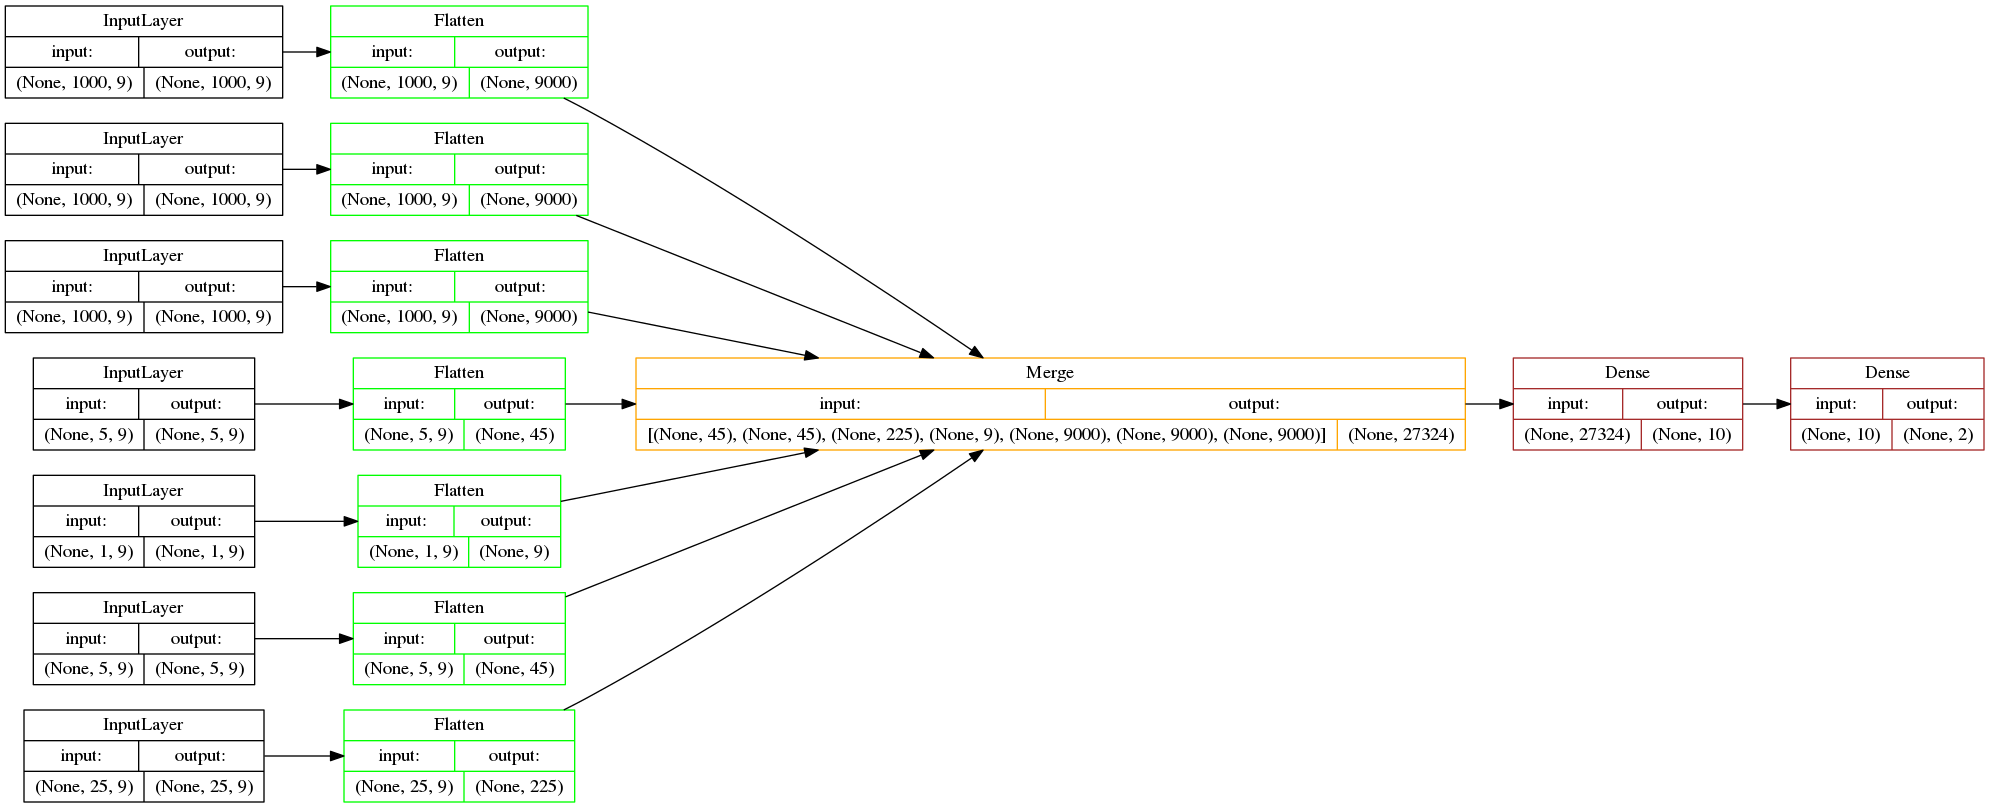

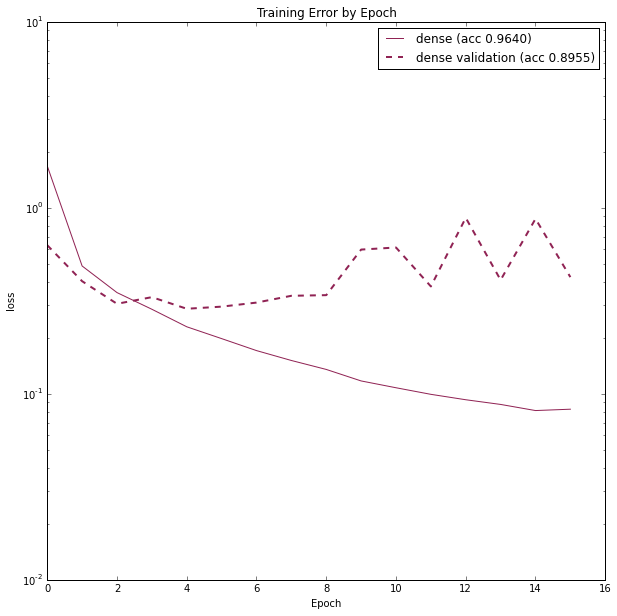

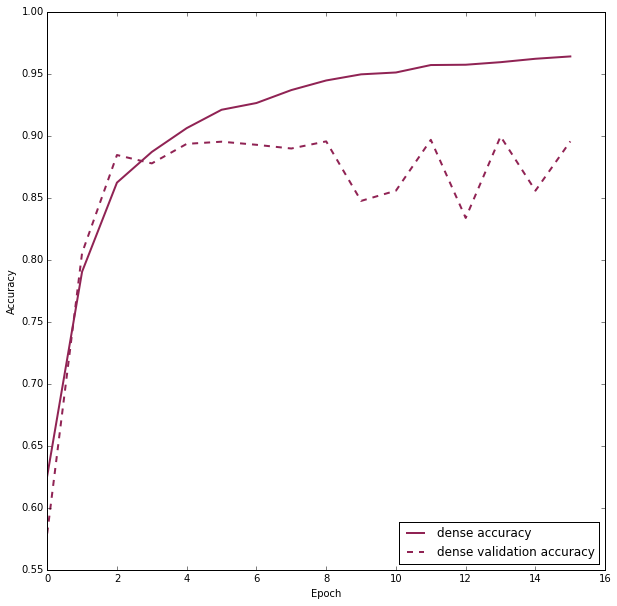

0c9b1d58c88de868bbbb38e4750979861be4272f: Best Validation accuracy: 0.8995


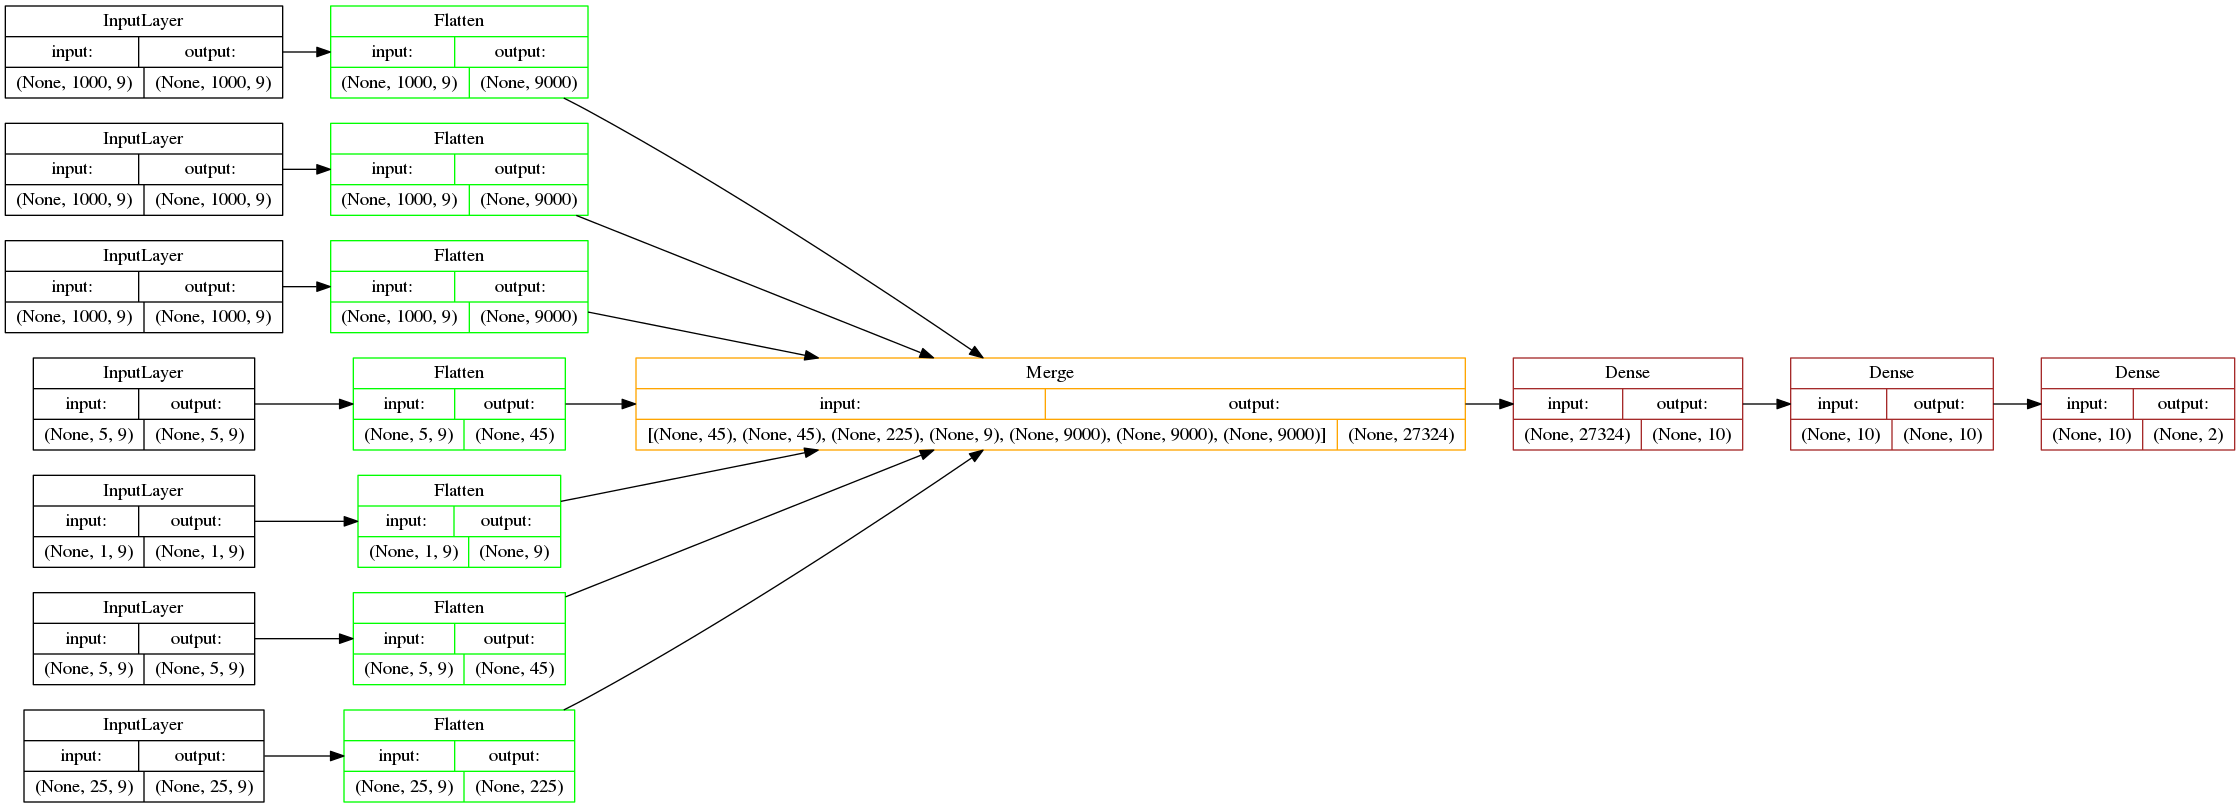

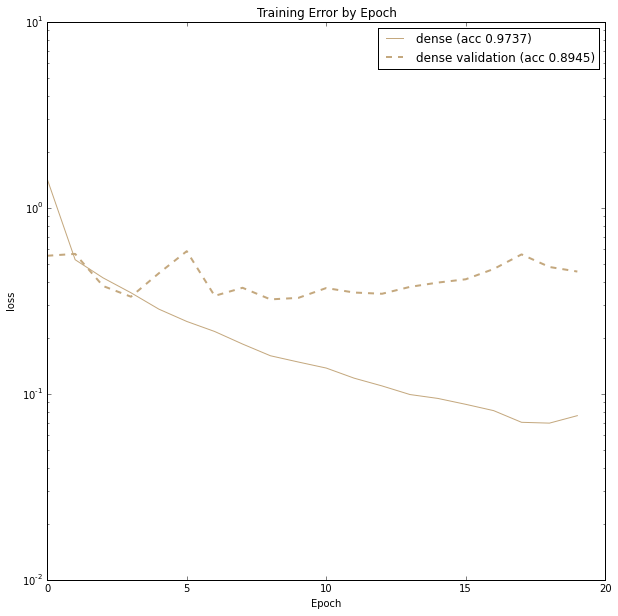

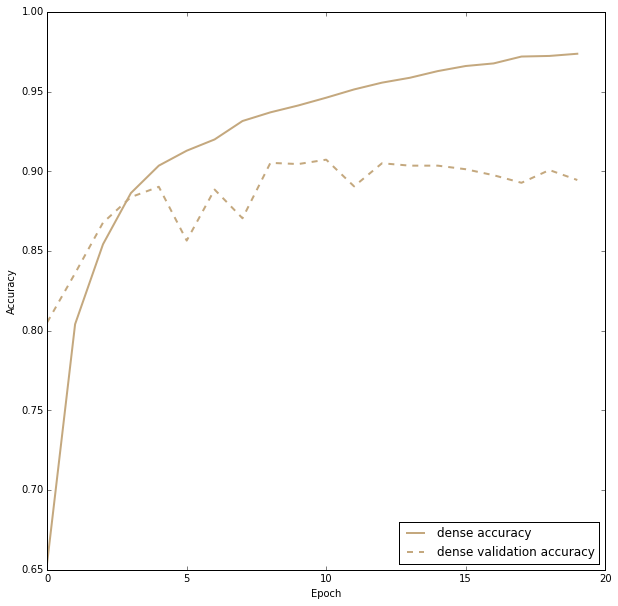

89f8b71a117662b9fc50a70eb7df9997eff93786: Best Validation accuracy: 0.9072


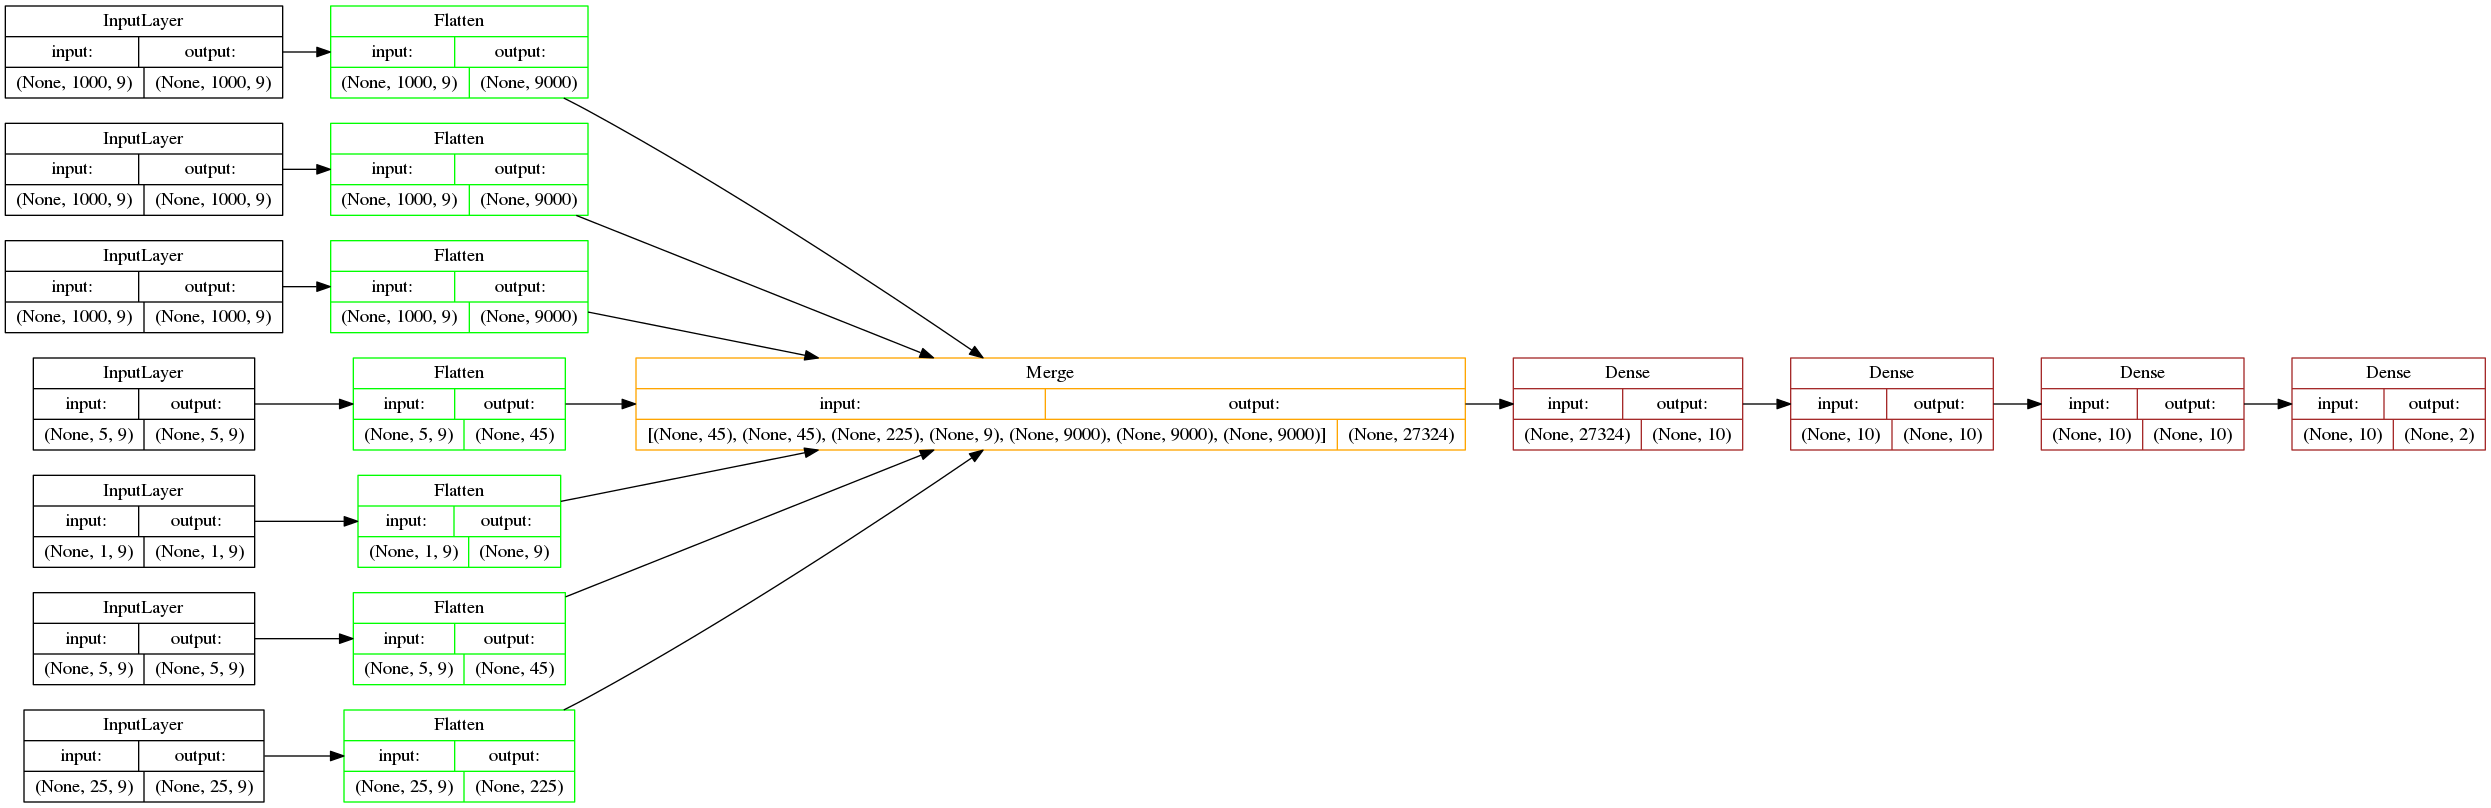

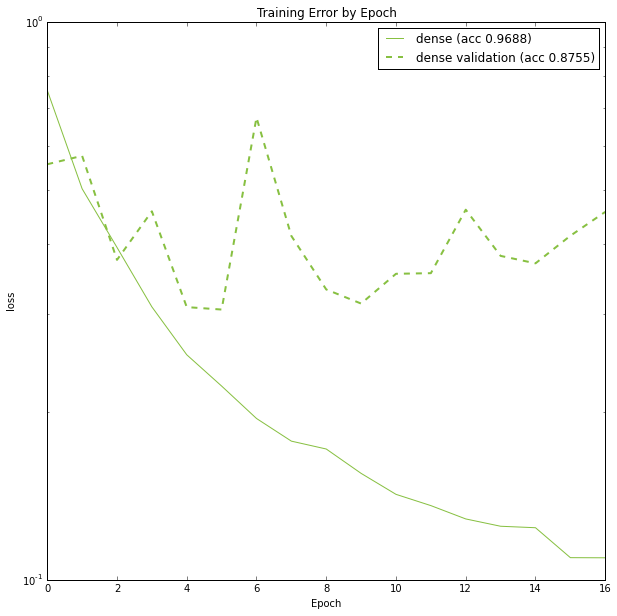

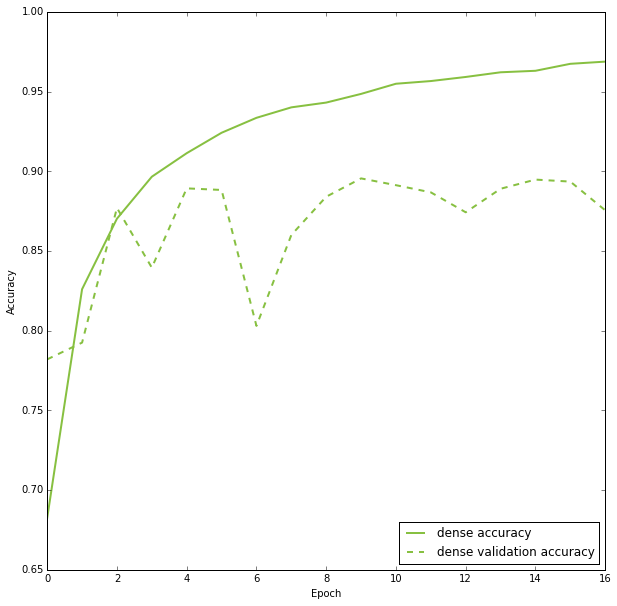

6c3523ad0590b008211cf201e254998e749128eb: Best Validation accuracy: 0.8955


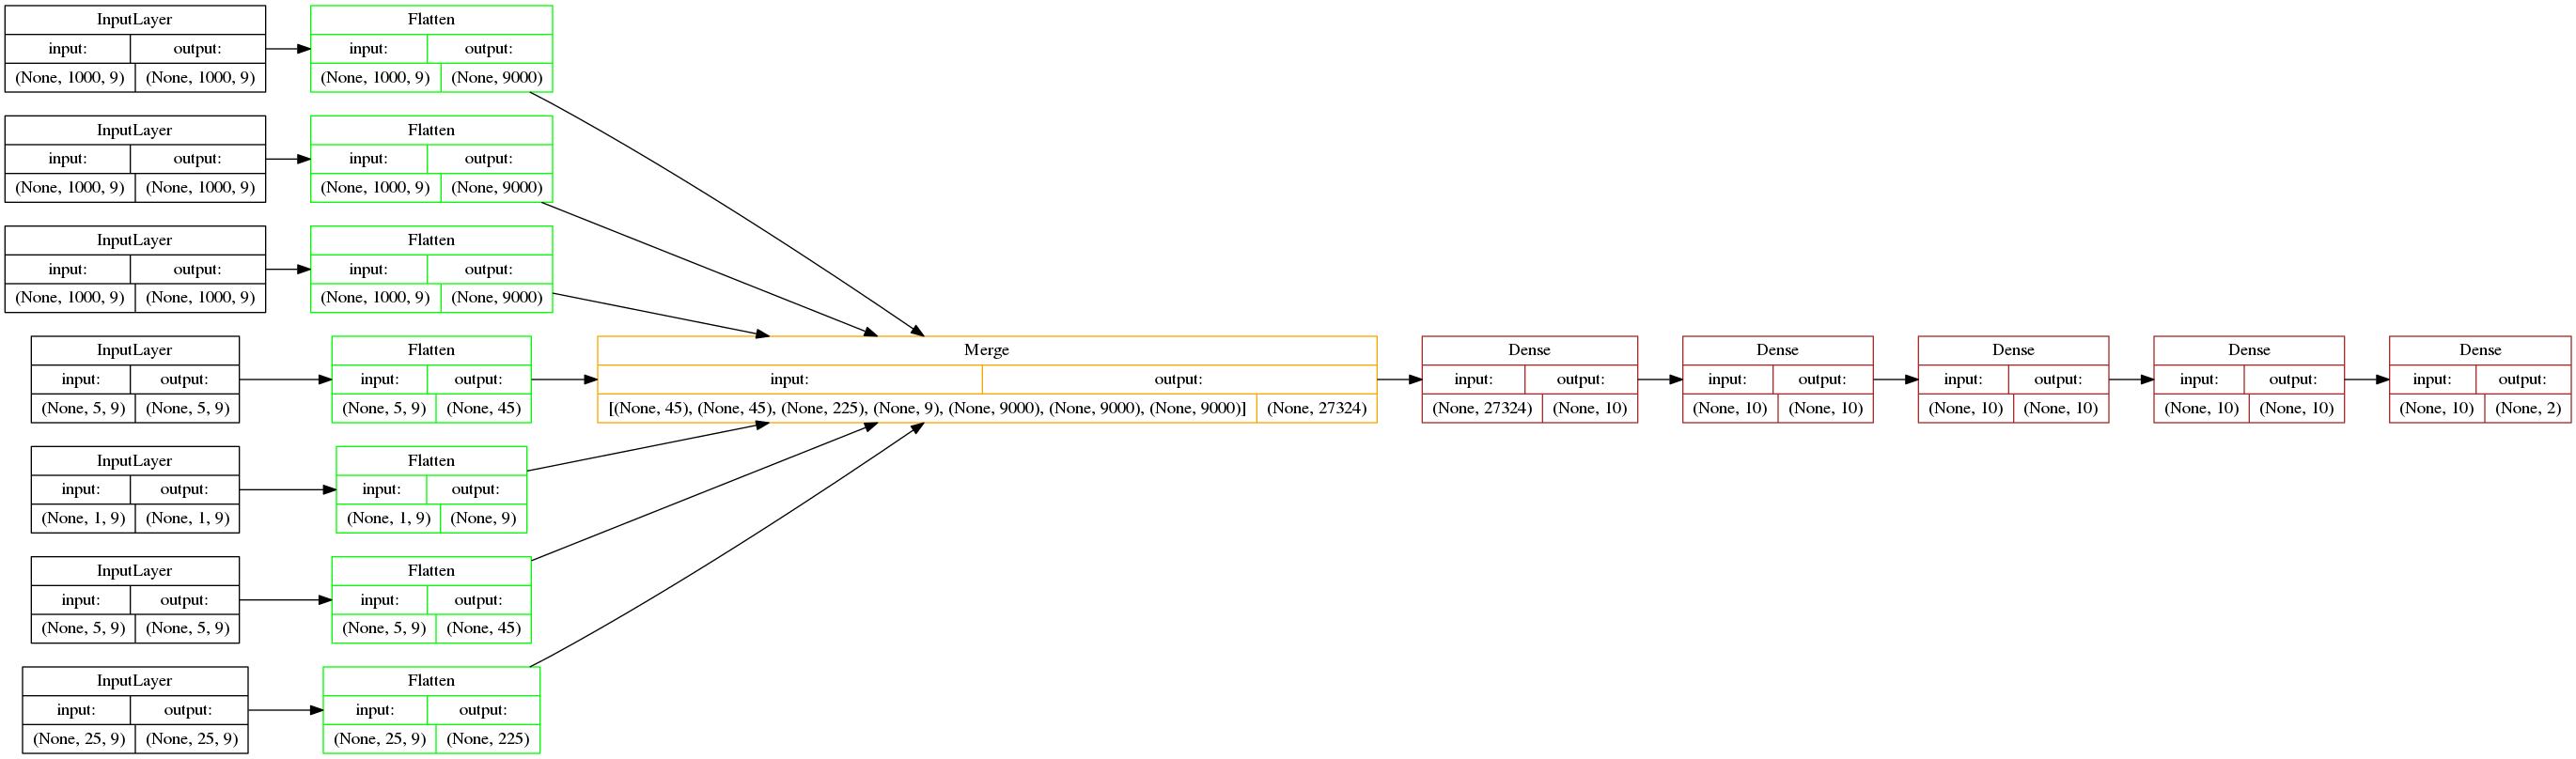

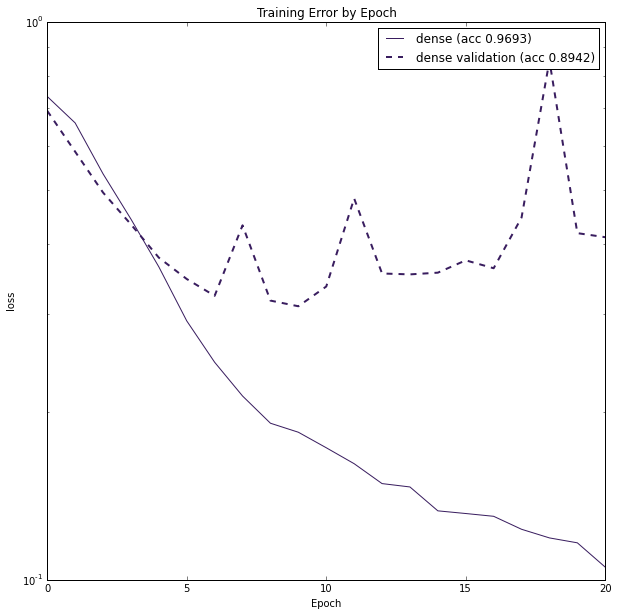

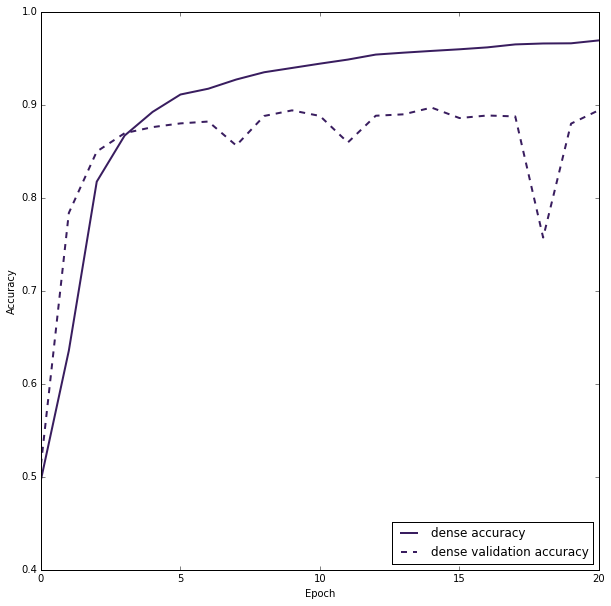

707e9eb0f3e305e025385db982beb04f5f5c1659: Best Validation accuracy: 0.8970


In [7]:
for trial, image, histDict, val_acc in histories:
    display(image)
    history = History()
    history.history = histDict
    plot_history([("dense", history)])
    print(trial.hash() + ': Best Validation accuracy: %s' % "{:0.4f}".format(val_acc))
    
    

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


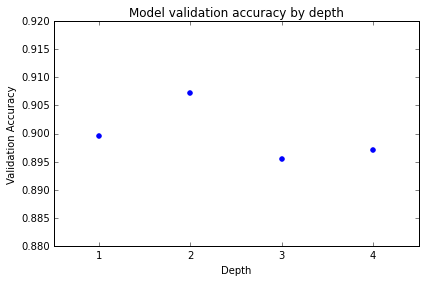

In [8]:
import matplotlib.pyplot as plt
bar_width = 0.35
depths = [ trial.get_from_index("depth") for trial, image, histDict, val_acc in histories]
index = np.arange(len(depths))
accuracies = [val_acc for trial, image, histDict, val_acc in histories]

rects1 = plt.scatter(index, accuracies,
                 color='b',
                 label='Men')


plt.xlabel('Depth')
plt.ylabel('Validation Accuracy')
plt.title('Model validation accuracy by depth')
plt.xticks(index, depths)
#plt.legend()

plt.tight_layout()
plt.show()

In [9]:

#smartCheckpoint = SmartCheckpoint("dense"+add_title)
#RUN Dense
#dense_history = dense.fit(X_train_flatten, y_train,
#                    batch_size=batch_size,
#                    nb_epoch=epochs,
 #                   validation_split=.2,
#                    callbacks=[earlyStopping, overfitStopping])
#histories["dense"+add_title] = (dense,dense_history,X_train_flatten, y_train)

In [10]:
keys = [key for key in histories]
def p(key):
    tup = histories[key]
    model = tup[0]
    history = tup[1]
    #print_accuracy_m(model, tup[2], tup[3])
    print(key + ': Best Validation accuracy: %r%%' % max(history.history["val_acc"]))
    plot_history([(key, history)])


In [11]:
p(keys[0])

TypeError: list indices must be integers, not tuple

In [ ]:
p(keys[1])

In [ ]:
p(keys[2])

In [ ]:
p(keys[3])

# import json
class KerasStore:
    def __init__(self,
                    label_dir_pairs=None,
                    num_samples=None,
                    object_profiles=None,
                    observ_types=None,
                )
    def to_JSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
    
a = Object()
a.label_dir_pairs = label_dir_pairs
a.num_samples = num_samples
a.object_profiles = object_profiles
a.observ_types = observ_types


f = JSONDecoder(object_hook = from_json).decode('{"fname": "/foo/bar"}')
print("JSON:")
print(a.to_JSON())



def setPreprocessingInfo(label_dir_pairs, num_samples, object_profiles, observ_types):
    hashString = ""
    for x, y in label_dir_pairs:
        hashString += x
        hashString += y
    hashString += num_samples
    for x in object_profiles:
        hashString += str(x)
    for x in observ_types:
        hashString += x
    
   